In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

#SKlearn importsl
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler

#Kaggle import
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

#TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large

2025-04-26 15:30:51.725523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-26 15:30:51.725553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-26 15:30:51.726775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 15:30:51.733008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-26 15:30:52.429388: W tensorflow/compiler/tf2

In [2]:
# Load dataset
def load_dataset(dir_path):
    """
    Load dataset from a given directory path. Normalizes and reshapes the data for the machine learning model.
    
    Args:
        dir_path (str): Path to the dataset directory.
    
    Returns:
        tuple: A tuple containing:
            - training_dataset (np.array): Array of training data.
            - testing_dataset (np.array): Array of testing data.
            - label_train (pd.DataFrame): DataFrame of training labels.
            - label_test (pd.DataFrame): DataFrame of testing labels.
    """
    
    train_path = os.path.join(dir_path, 'Train')
    test_path = os.path.join(dir_path, 'Test')
    
    label_training = os.path.join(dir_path, 'label_train.csv')
    label_testing = os.path.join(dir_path, 'test_format.csv')
    
    # List directories and sort them by their ID
    training_files = sorted(os.listdir(train_path), key = lambda x: int(x.split('.')[0]))
    testing_files = sorted(os.listdir(test_path), key = lambda x: int(x.split('.')[0]))
    
    # Load training and testing datasets
    training_dataset = []
    for path in training_files:
        if path.endswith('.npy'):
            train_data = np.load(os.path.join(train_path, path))
            training_dataset.append(train_data)
            
    testing_dataset = []
    for path in testing_files:
        if path.endswith('.npy'):
            test_data = np.load(os.path.join(test_path, path))
            testing_dataset.append(test_data)
    
    # Load labels
    label_train = pd.read_csv(label_training)
    label_test = pd.read_csv(label_testing)
    
    # Converts lists to numpy arrays
    training_dataset = np.array(training_dataset)
    testing_dataset = np.array(testing_dataset)
    
    # Normalizes and reshapes the data
    train_normalized = (training_dataset - training_dataset.min()) / (training_dataset.max() - training_dataset.min())
    train_reshaped = train_normalized.reshape(-1, 72, 48, 1)
    
    testing_normalized = (testing_dataset - testing_dataset.min()) / (testing_dataset.max() - testing_dataset.min())
    testing_reshaped = testing_normalized.reshape(-1, 72, 48, 1)
    
    print(f"Training dataset shape: {training_dataset.shape}")
    print(f"Testing dataset shape: {testing_dataset.shape}")
    
    return train_reshaped, testing_reshaped, label_train, label_test

In [3]:
def oversample_dataset(dataset, labels, noise=False):
    """
    Oversample the dataset to balance the classes. With the abbility to add noise to the data.
    
    Args:
        dataset (np.array): The dataset to be oversampled.
        labels (pd.DataFrame): The labels corresponding to the dataset.
        noise (bool): If True, adds noise to the oversampled data.
    
    Returns:
        tuple: A tuple containing:
            - oversampled_dataset (np.array): The oversampled dataset.
            - oversampled_labels (pd.DataFrame): The oversampled labels.
    """
    
    # Count the number of samples in each class
    class_counts = labels['target'].value_counts()
    
    # Find the maximum class count
    max_count = class_counts.max()
    
    # Create a new list to hold the oversampled data
    oversampled_data = []
    oversampled_labels = []
    
    for label, count in class_counts.items():
        # Get the indices of the samples for this label
        indices = labels[labels['target'] == label].index.tolist()
        
        # Randomly sample with replacement to reach max_count
        sampled_indices = np.random.choice(indices, max_count, replace=True)
        
        # Append the sampled data and labels to the new lists
        for idx in sampled_indices:
            if noise:
                # Add noise to the data
                noise_data = dataset[idx] + np.random.normal(0, 0.01, dataset[idx].shape)
                oversampled_data.append(noise_data)
                oversampled_labels.append(labels.iloc[idx])
            else:
                oversampled_data.append(dataset[idx])
                oversampled_labels.append(labels.iloc[idx])
    
    return np.array(oversampled_data), pd.DataFrame(oversampled_labels)

In [4]:
def oversample_synthetic(train_data, train_labels):
    """
    Apply SMOTE to the training data to balance the classes.
    
    Args:
        train_data (np.array): The training data.
        train_labels (pd.DataFrame): The training labels.
    
    Returns:
        tuple: A tuple containing:
            - X_resampled (np.array): The oversampled training data.
            - y_resampled (pd.DataFrame): The oversampled training labels.
    """
    
   # Oversampling the training dataset using SMOTE
    SMOTE = SMOTE(random_state=42)
    # Flatten training data
    train_flat = train.reshape(train.shape[0], -1)
    # Apply SMOTE
    train_flat, train_labels = SMOTE.fit_resample(train_flat, train_labels['target'])
    # Unflatten
    train = train_flat.reshape(-1, 72, 48, 1)
    # Convert labels to DataFrame
    train_labels = pd.DataFrame(train_labels, columns=['target'])
    
    return train, train_labels

Training dataset shape: (1491, 72, 48)
Testing dataset shape: (120, 72, 48)


Before oversampling and splitting:
Train input (1341, 72, 48, 1)
Train labels: (1341, 2)
Validation input: (150, 72, 48, 1)
Validation labels: (150, 2)


After oversampling and splitting:
Train input (3261, 72, 48, 1)
Train labels: (3261, 3)
Validation input: (150, 72, 48, 1)
Validation labels: (150, 3)
Testing input: (120, 72, 48, 1)


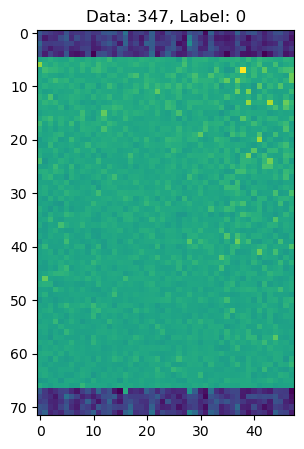

In [5]:
train, test, train_labels, test_labels = load_dataset('Dataset/')

# Split the dataset into training and validation sets to prevent overfitting
train, val, train_labels, val_labels = train_test_split(
    train, train_labels, test_size=0.1, stratify=train_labels['target']
)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

print('\n')
print('Before oversampling and splitting:')
print('Train input', train.shape)
print('Train labels:', train_labels.shape)
print('Validation input:', val.shape)
print('Validation labels:', val_labels.shape)

# Oversample training data
train, train_labels = oversample_dataset(train, train_labels, noise=False)

# Remove the ID column
val_labels = val_labels.drop(columns=['ID'])

# Convert labels to int
train_labels['target'] = train_labels['target'].astype(int)

# Shuffle the training data
permutation = np.random.permutation(len(train))
train = train[permutation]
train_labels = train_labels.iloc[permutation].reset_index(drop=True)

# Convert labels to one-hot encoding
all_classes = sorted(set(train_labels['target']).union(set(test_labels['target'])))
train_labels_coded = pd.get_dummies(train_labels['target']).reindex(columns=all_classes, fill_value=False)
val_labels_coded = pd.get_dummies(val_labels['target']).reindex(columns=all_classes, fill_value=False)

# Print shapes of the datasets
print('\n')
print('After oversampling and splitting:')
print('Train input', train.shape)
print('Train labels:', train_labels_coded.shape)
print('Validation input:', val.shape)
print('Validation labels:', val_labels_coded.shape)
print('Testing input:', test.shape)

# Display a random entry from the training dataset
plt.figure(figsize=(5, 5))
random_entry = np.random.randint(0, len(train))
plt.imshow(train[np.random.randint(0, len(train))].reshape(72, 48))
plt.title(f"Data: {random_entry}, Label: {train_labels.iloc[random_entry]['target']}")
plt.show()

In [6]:
# Creating a model

#Convolutional Neural Network
model = Sequential([
    InputLayer(input_shape=(72, 48, 1)),
    Conv2D(16, (4, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (4, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    
    Dense(3, activation='softmax'),
])

# MobileNetV3Small
# model = Sequential([
#     InputLayer(input_shape=(72, 48, 1)),
#     MobileNetV3Small(input_shape=(72, 48, 1), include_top=False, weights=None),
#     AveragePooling2D(pool_size=(2, 2)),
#     Flatten(),
    
#     Dropout(0.2),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(len(all_classes), activation='softmax'),
# ])

batch_size = 8
n_of_epochs = 100
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
optim = Adam(learning_rate=0.001)

model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 47, 16)        144       
                                                                 
 max_pooling2d (MaxPooling2  (None, 34, 23, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 22, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 11, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 5280)              0         
                                                                 
 dense (Dense)               (None, 128)               6

2025-04-26 15:30:53.405306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-26 15:30:53.441146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-26 15:30:53.444025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
#Train the model
history = model.fit(train, train_labels_coded,
                     validation_data=(val, val_labels_coded), 
                     batch_size=batch_size, 
                     epochs=n_of_epochs,
                     callbacks=[lr_reducer, early_stopping],)

Epoch 1/100


2025-04-26 15:30:54.417810: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-04-26 15:30:55.222579: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8bf51b0c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-26 15:30:55.222607: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-04-26 15:30:55.230548: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745681455.353391  811863 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


408/408 [==============================] - 4s 4ms/step - loss: 0.9004 - accuracy: 0.5489 - val_loss: 0.3964 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 2/100
408/408 [==============================] - 1s 3ms/step - loss: 0.2738 - accuracy: 0.9117 - val_loss: 0.0442 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 3/100
408/408 [==============================] - 1s 3ms/step - loss: 0.1735 - accuracy: 0.9393 - val_loss: 0.0434 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 4/100
408/408 [==============================] - 1s 3ms/step - loss: 0.1565 - accuracy: 0.9445 - val_loss: 0.0720 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 5/100
408/408 [==============================] - 1s 3ms/step - loss: 0.1121 - accuracy: 0.9611 - val_loss: 0.0351 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 6/100
408/408 [==============================] - 1s 3ms/step - loss: 0.0593 - accuracy: 0.9810 - val_loss: 0.0976 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 7/100
408/408 [==============================] - 1s 3ms/step - loss: 0

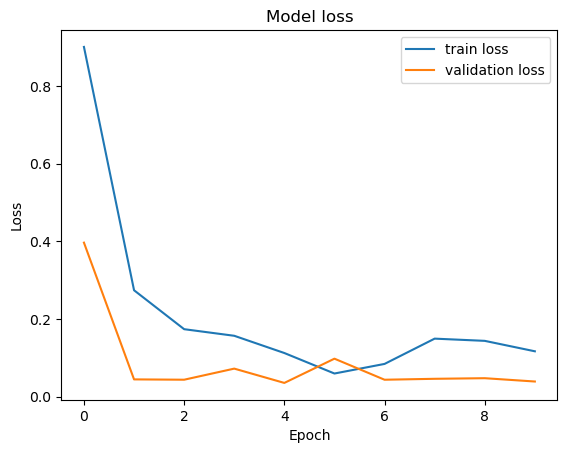

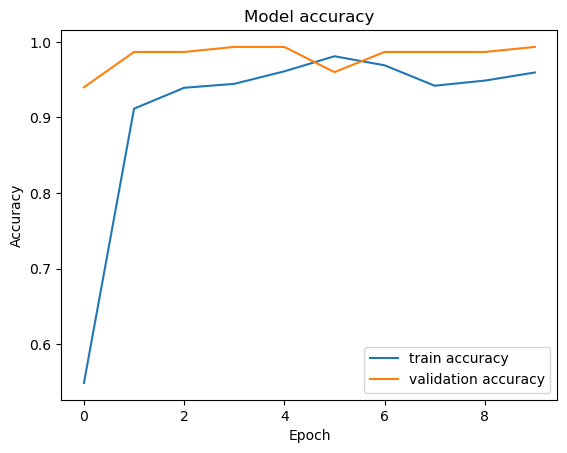

In [8]:
# Plot the training loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot the training accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Load correct labels for test
test_labels_solution = pd.read_csv('submission_with_one_error.csv')
test_labels_solution = pd.get_dummies(test_labels_solution['target']).reindex(columns=all_classes, fill_value=False)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(test, test_labels_solution, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predict on the test set
results = model.predict(test)
# Format results into same format as labels with one collumn
results = pd.DataFrame(results, columns=all_classes)
results['target'] = results.idxmax(axis=1)
results = results[['target']]
results = results.astype(int)
results = pd.concat([test_labels['ID'], results], axis=1)

# Save the results to a CSV file
results.to_csv('submission.csv', index=False)

if val_accuracy > 0.99:
    # Save the model
    model.save('model.keras')
    print("Model saved as 'model.keras'")

# Sumbit results to Kaggle
# api.competition_submit(
#    file_name='submission.csv',
#     message='Smaller convolution',
#     competition='mpa-mlf-2025-new'
# )

4/4 [==============================] - 0s 2ms/step - loss: 0.0781 - accuracy: 0.9917
Validation Loss: 0.07813937216997147
Validation Accuracy: 0.9916666746139526
4/4 [==============================] - 0s 1ms/step
Model saved as 'model.h5'


/home/snp/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
